# Análise exploratória de preços do Bitcoin (BTC/USDT)

Descrição resumida
- Script em Python para baixar OHLCV do par BTCUSDT da API da Binance, limpar e preparar os dados, calcular métricas/indicadores simples e gerar visualizações exploratórias.
- Etapas implementadas: coleta, limpeza, estatísticas descritivas, visualizações, correlação e feature engineering (médias móveis e volatilidade).

Dependências
- requests
- pandas
- numpy
- matplotlib
- seaborn

Instalação (exemplo)
```bash
pip install requests pandas numpy matplotlib seaborn
```

Principais funções/variáveis
- get_binance_ohlc(symbol="BTCUSDT", interval="1d", start=1493596800000, end=None)
    - Baixa candles (klines) da Binance e retorna DataFrame com colunas convertidas (datas e numéricos).
    - Parâmetro start em milissegundos (default começa em 2017).
- btc_df
    - DataFrame final filtrado para ["open_time", "open", "high", "low", "close", "volume"] e ordenado por data.
    - Colunas adicionadas: `return` (pct_change), `SMA_7`, `SMA_30`, `volatilidade_7d`.

Outputs / Visualizações geradas
- Série temporal do preço de fechamento.
- Gráfico de volume diário.
- Histograma + KDE da distribuição dos retornos diários.
- Heatmap da matriz de correlação entre variáveis.
- Gráfico do preço com médias móveis (7d e 30d).
- Estatísticas descritivas impressas e contagem de linhas analisadas.

Observações importantes
- Requer conexão com a internet e acesso à API pública da Binance.
- Atenção a limites de taxa da API; para séries longas pagine chamadas ou implemente cache.
- O start padrão (1493596800000) é em ms; ajuste para período desejado.
- Valores NaN aparecem nas primeiras linhas ao calcular médias móveis e retornos (comportamento esperado).

Melhorias sugeridas
- Salvar o DataFrame em CSV/Parquet para análises futuras e evitar múltiplas chamadas.
- Implementar tratamento de exceções mais robusto e retry/backoff para requisições.
- Adicionar normalização, features adicionais (RSI, MACD) e pipeline para modelagem/forecast.
- Incluir argumentos CLI ou widgets para escolher período, símbolo e intervalo.

Licença
- Livre para uso/ajuste (adapte conforme necessidade do projeto).

In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time

import seaborn as sns

def get_full_binance_ohlc(symbol="BTCUSDT", interval="1d",
                          start_date="2019-01-01", end_date=None):
    url = "https://api.binance.com/api/v3/klines"
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000) if end_date else int(time.time() * 1000)

    all_data = []
    limit = 1000  # limite máximo por requisição

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_timestamp,
            "endTime": end_timestamp,
            "limit": limit
        }

        r = requests.get(url, params=params)
        r.raise_for_status()
        data = r.json()

        if not data:
            break

        all_data.extend(data)
        last_close_time = data[-1][6]  # coluna 'close_time'
        start_timestamp = last_close_time + 1  # próxima vela

        if start_timestamp >= end_timestamp:
            break

        time.sleep(0.2)  # evita limite de requisições da Binance

    cols = ["open_time", "open", "high", "low", "close", "volume",
            "close_time", "quote_volume", "num_trades",
            "taker_base_vol", "taker_quote_vol", "ignore"]

    df = pd.DataFrame(all_data, columns=cols)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df[["open", "high", "low", "close", "volume"]] = \
        df[["open", "high", "low", "close", "volume"]].astype(float)

    return df

# ==============================
# Buscar dados completos (2019 até hoje)
# ==============================
btc_df = get_full_binance_ohlc("BTCUSDT", "1d", "2019-01-01")

In [11]:
# ==============================
# Preparação e análise
# ==============================
btc_df = btc_df[["open_time", "open", "high", "low", "close", "volume"]]
btc_df = btc_df.sort_values("open_time").reset_index(drop=True)
btc_df["return"] = btc_df["close"].pct_change()

print(f"Período: {btc_df['open_time'].min().date()} até {btc_df['open_time'].max().date()}")
print("\nResumo estatístico:")
print(btc_df.describe())

# ==============================
# LIMPEZA E PREPARAÇÃO
# ==============================
# Remover colunas desnecessárias
btc_df = btc_df[["open_time", "open", "high", "low", "close", "volume"]]

# Verificar valores nulos
print("Valores nulos:\n", btc_df.isna().sum())

# Garantir que está ordenado por data
btc_df = btc_df.sort_values("open_time").reset_index(drop=True)

# Adicionar uma coluna de 'retorno diário'
btc_df["return"] = btc_df["close"].pct_change()


Período: 2019-01-01 até 2025-11-12

Resumo estatístico:
                 open_time           open           high            low  \
count                 2508    2508.000000    2508.000000    2508.000000   
mean   2022-06-07 12:00:00   40519.809988   41372.401368   39616.166575   
min    2019-01-01 00:00:00    3398.400000    3426.450000    3349.920000   
25%    2020-09-18 18:00:00   11660.010000   11883.250000   11279.222500   
50%    2022-06-07 12:00:00   30601.460000   31480.000000   29983.000000   
75%    2024-02-24 06:00:00   59239.667500   60875.222500   57951.587500   
max    2025-11-12 00:00:00  124658.540000  126199.630000  123084.000000   
std                    NaN   31848.643995   32359.469711   31303.891412   

               close         volume       return  
count    2508.000000    2508.000000  2507.000000  
mean    40559.020068   70292.752608     0.001868  
min      3398.400000    3282.173520    -0.395048  
25%     11677.000000   27503.074302    -0.012549  
50%     30619

In [12]:
# ==============================
# ESTATÍSTICAS DESCRITIVAS
# ==============================
print("\nResumo estatístico dos preços:")
print(btc_df[["open", "high", "low", "close", "volume", "return"]].describe())



Resumo estatístico dos preços:
                open           high            low          close  \
count    2508.000000    2508.000000    2508.000000    2508.000000   
mean    40519.809988   41372.401368   39616.166575   40559.020068   
std     31848.643995   32359.469711   31303.891412   31863.741080   
min      3398.400000    3426.450000    3349.920000    3398.400000   
25%     11660.010000   11883.250000   11279.222500   11677.000000   
50%     30601.460000   31480.000000   29983.000000   30619.565000   
75%     59239.667500   60875.222500   57951.587500   59349.732500   
max    124658.540000  126199.630000  123084.000000  124658.540000   

              volume       return  
count    2508.000000  2507.000000  
mean    70292.752608     0.001868  
std     82311.143589     0.033051  
min      3282.173520    -0.395048  
25%     27503.074302    -0.012549  
50%     43873.587388     0.000709  
75%     74828.685041     0.015537  
max    760705.362783     0.195361  


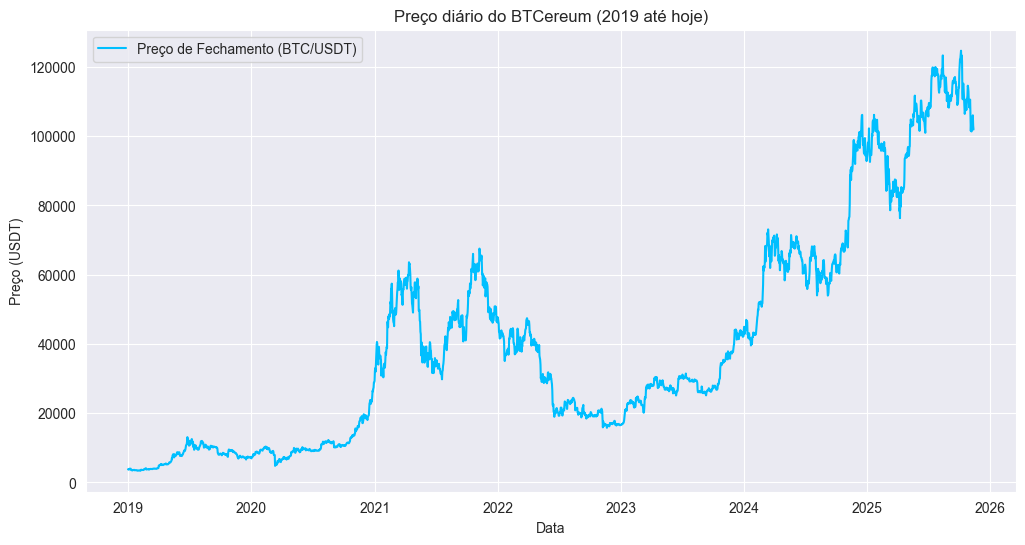

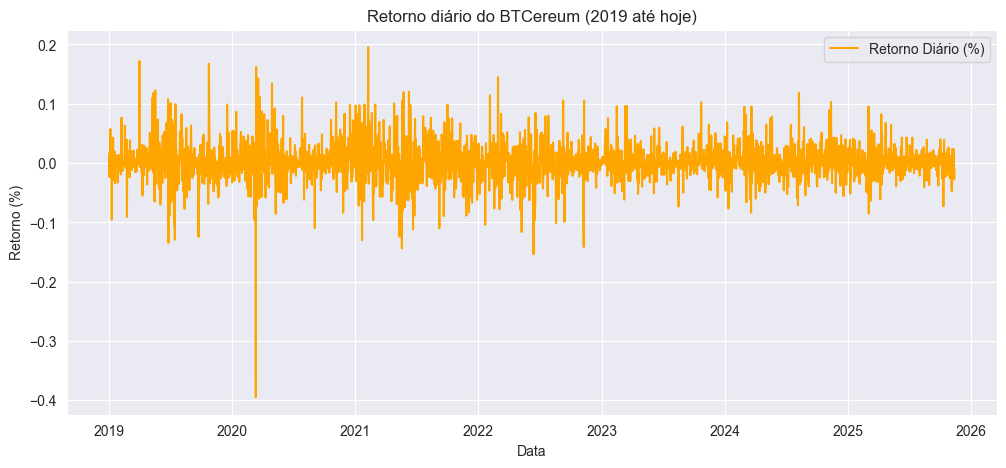

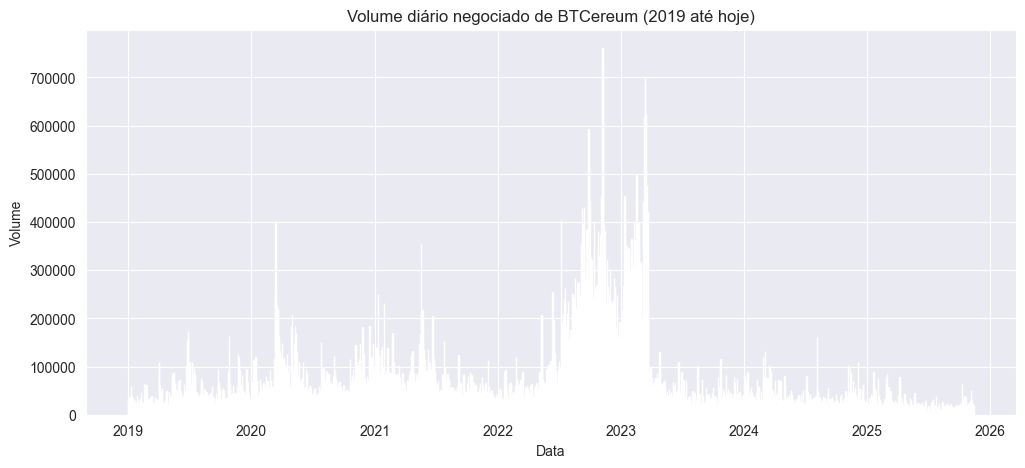

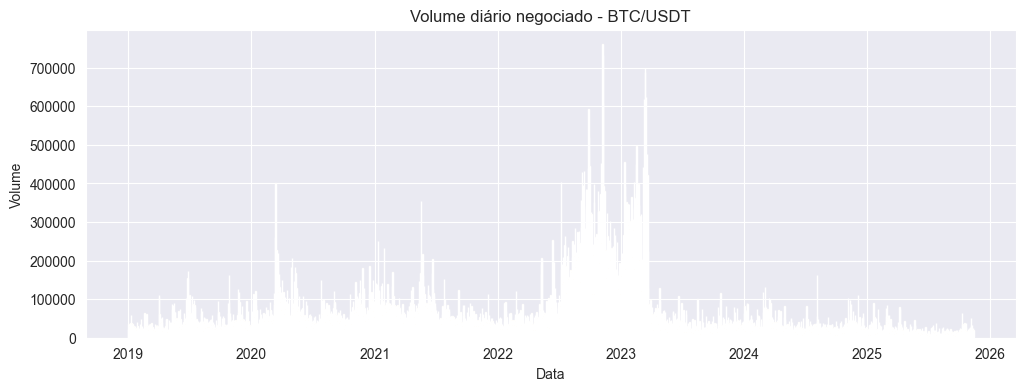

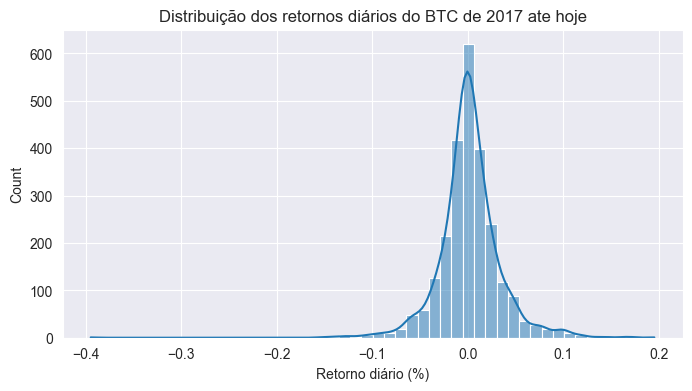

In [13]:
# ==============================
# Gráfico de preço
# ==============================
plt.figure(figsize=(12,6))
plt.plot(btc_df["open_time"], btc_df["close"], label="Preço de Fechamento (BTC/USDT)", color="deepskyblue")
plt.title("Preço diário do BitCoin (2019 até hoje)")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()


# Gráfico 2: Retornos diários
plt.figure(figsize=(12,5))
plt.plot(btc_df["open_time"], btc_df["return"], color='orange', label="Retorno Diário (%)")
plt.title("Retorno diário do BitCoin (2019 até hoje)")
plt.xlabel("Data")
plt.ylabel("Retorno (%)")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 3: Volume negociado
plt.figure(figsize=(12,5))
plt.bar(btc_df["open_time"], btc_df["volume"], color='purple')
plt.title("Volume diário negociado de BitCoin (2019 até hoje)")
plt.xlabel("Data")
plt.ylabel("Volume")
plt.grid(True)
plt.show()


# Volume negociado
plt.figure(figsize=(12,4))
plt.bar(btc_df["open_time"], btc_df["volume"], color="orange")
plt.title("Volume diário negociado - BTC/USDT")
plt.xlabel("Data")
plt.ylabel("Volume")
plt.show()

# Distribuição dos retornos
plt.figure(figsize=(8,4))
sns.histplot(btc_df["return"].dropna(), bins=50, kde=True)
plt.title("Distribuição dos retornos diários do BTC de 2017 ate hoje")
plt.xlabel("Retorno diário (%)")
plt.show()


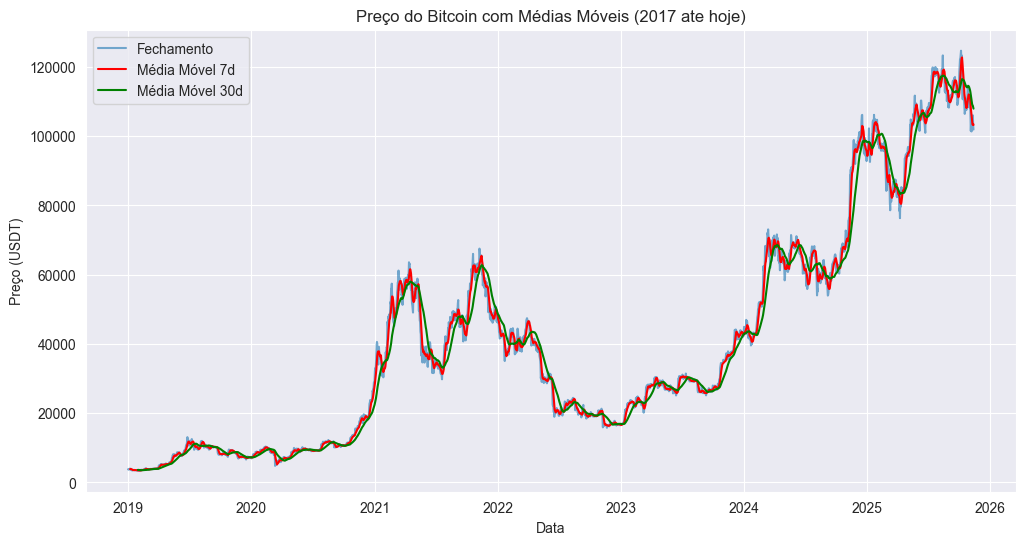

In [14]:
# ====FEATURE ENGINEERING (para predição futura)
# ==============================
# Médias móveis (tendência)
btc_df["SMA_7"] = btc_df["close"].rolling(window=7).mean()   # 1 semana
btc_df["SMA_30"] = btc_df["close"].rolling(window=30).mean() # 1 mês

# Volatilidade (desvio padrão dos retornos)
btc_df["volatilidade_7d"] = btc_df["return"].rolling(window=7).std()

# Gráfico com médias móveis
plt.figure(figsize=(12,6))
plt.plot(btc_df["open_time"], btc_df["close"], label="Fechamento", alpha=0.6)
plt.plot(btc_df["open_time"], btc_df["SMA_7"], label="Média Móvel 7d", color="red")
plt.plot(btc_df["open_time"], btc_df["SMA_30"], label="Média Móvel 30d", color="green")
plt.title("Preço do Bitcoin com Médias Móveis (2017 ate hoje)")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# ==============================
# Resultado final
# ==============================
print("Análise exploratória concluída com sucesso!")
print("Linhas analisadas:", len(btc_df))
btc_df.tail()


Análise exploratória concluída com sucesso!
Linhas analisadas: 2508


,open_time,open,high,low,close,volume,return,SMA_7,SMA_30,volatilidade_7d
2503,2025-11-08,103339.09,103406.22,101454.00,102312.94,12390.77985,-0.009930,104214.880000,109201.178333,0.027379
2504,2025-11-09,102312.95,105495.62,101400.00,104722.96,16338.97096,0.023555,103383.777143,108932.793667,0.029934
2505,2025-11-10,104722.95,106670.11,104265.02,106011.13,22682.25673,0.012301,103302.075714,108778.351333,0.027743
2506,2025-11-11,106011.13,107500.00,102476.09,103058.99,24196.50718,-0.027847,103525.185714,108381.691000,0.022647
2507,2025-11-12,103059.00,105333.33,100813.59,101913.34,20114.67309,-0.011116,103243.497143,107939.935667,0.020987
